# Langchain + Self_RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

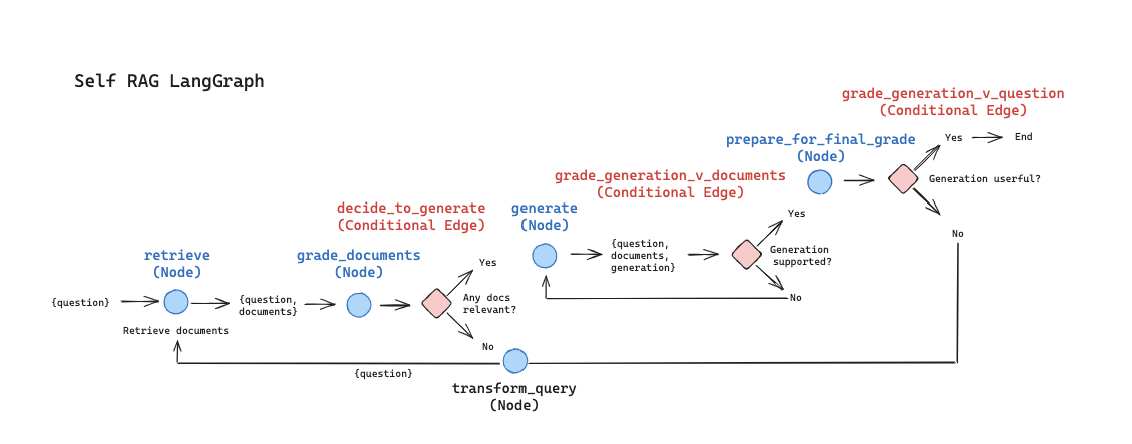

In [1]:
OPENAI_API_KEY="sk-"

## Define State Object

In [2]:
from typing import Dict, TypedDict

class Graph_state(TypedDict):
    """at each node, the Graph_state got updated. this object is pass between nodes"""
    key: Dict[str, any]

## Create a Retriever

In [3]:
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_openai import OpenAIEmbeddings

In [4]:
# read json doc
with open ('data.txt') as f:
    data=json.load(f)
    

# Extract text from the JSON data
text=""
for category, items in data.items():
    for item in items:
        text += f"{item['name']}. {item['description']}{item['price']}.{item['ingredients']}.{item['options']}.{item['availability']}. "

# split the text documents to chunks & generate the vector embeddings

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

chunks = text_splitter.create_documents([text])

embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

db = DocArrayInMemorySearch.from_documents(chunks, embeddings)

In [5]:
retriever=db.as_retriever()

## Define Nodes

1. retrieve</br>
2. grade_documents</br>
3. generate</br>
4. prepare_for_final_grade</br>
5. transform</br>

**1.Retrieve**

In [6]:
def retrieve(state):
    """
    retrieve relevant documents to user based on their question.
    """
    
    question=state['key']['question']
    docs=retriever.get_relevant_documents(question)
    
    return {'key':{'question':question,'documents':docs}}

**2. grade_documents**

In [7]:
from langchain import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticToolsParser

In [8]:
def grade_documents(state):
    """grade the retrieved documents"""
    print("---Grading documents---")
    
    question=state['key']['question']
    documents=state['key']['documents']
    
    model = ChatOpenAI(model="gpt-3.5-turbo",api_key=OPENAI_API_KEY,streaming=True)
    
    # create a pydantic object to add the validation
    class grade(BaseModel):
        binary_out: str =Field(description="Relevance score 'yes' or 'no'")
            
    parser=PydanticToolsParser(tools=[grade])
    
    grade_tool_oai = convert_to_openai_tool(grade)
    
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )
    
    prompt=PromptTemplate(template="""
    You are a document Grader. you will check the relevance of context to the {question}.
    you will check the context {context} contains the keywords in question or not.
    
    based on your check, you will return 'yes' if the context is relevant, else you will return a 'no'.
    """,
    input_variables=["question", "context"])
    
    relevance_chain=prompt|llm_with_tool|parser

    filtered_docs=[]
    
    for d in documents:
        score = relevance_chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_out
        grade=grade.lower() 
        if grade == "yes":
            print("---GRADE: Relevant document---")
            filtered_docs.append(d)
        else:
            print("---GRADE: Irrelevant document---")
            continue
            
    return {"key":{'question':question, 'documents':filtered_docs}}

**3. Generate**

In [9]:
from langchain.schema.output_parser import StrOutputParser

In [10]:
def generate(state):
    
    """generate a response"""
    print("---Generate Response---")
    question=state['key']['question']
    context=state['key']['documents']
    
    
    model = ChatOpenAI(model="gpt-3.5-turbo",api_key=OPENAI_API_KEY,streaming=True)
    prompt=PromptTemplate(
    template="""
    Generate a response to user question based on the context.
    context:{context}
    question: {question}
    """,input_variables=['question','context']
    )
    
    rag_chain=prompt|model|StrOutputParser()
    
    response= rag_chain.invoke({'question':question, 'context':context})
    
    #print({'key':{'question':question,'documents':context, 'generation':response}})
    return {'key':{'question':question,'documents':context, 'generation':response}}

**4. Prepare_for_final_grade**

In [11]:
def prepare_for_final_grade(state):
    question=state['key']['question']
    generation=state['key']['generation']
    documents=state['key']['documents']
    print("Final grade completed")
    return {'key':{'question':question,'generation':generation,'documents':documents}}

**5. Transform Query**

In [12]:
def transform(state):
    """transform query"""
    print("---Transform Query---")
    question=state['key']['question']
        
    model = ChatOpenAI(model="gpt-3.5-turbo",api_key=OPENAI_API_KEY,streaming=True)
    prompt=PromptTemplate(
    template="""
    Re write the question that is compatible to do the search.
    question: {question}
    """,input_variables=['question']
    )
    
    transform_chain=prompt|model|StrOutputParser()
    
    better_question= transform_chain.invoke({'question':question})
    
    return {'key':{'question':better_question}}

## Define the Helper Function

1. Any_docs_relevant</br>
2. grade_generation_vs_docs</br>
3. generation_useful</br>

**1. Any_docs_relevant**

In [13]:
# check the document is empty list or not

In [14]:
def any_docs_relevant(state):
    print("---check the documents list is empty or no")
    filtered_docs=state['key']['documents']
    
    if filtered_docs==[]:
        return "transform_query"
    else:
        return "generate"

**2. grade_generation_vs_docs**

In [15]:
def grade_generation_vs_docs(state):
    
    print("---generation vs docs---")
    question = state['key']["question"]
    documents=state['key']['documents']
    response=state['key']['generation']

    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True,api_key=OPENAI_API_KEY,)
    
    # create a pydantic object to add the validation
    class grade_generation(BaseModel):
        binary_out:str=Field(description="Supported score 'yes' or 'no'")
            
    parser=PydanticToolsParser(tools=[grade_generation])
    
    grade_tool_oai = convert_to_openai_tool(grade_generation)
    
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade_generation"}},
    )
    
    prompt=PromptTemplate(
    template="""
    You are a response grader. you have to check the response is based on documents.
    you can return either 'yes' or 'no' based on comparison.
    documents:{documents}
    response: {response}
    
    """,input_variables=['documents','response']
    )
    
    relevance_chain=prompt|llm_with_tool|parser
    
    
    score=relevance_chain.invoke({'documents':documents,'response':response})
    grade = score[0].binary_out
    grade=grade.lower() 
    
    print(f"grade={grade}")
    
    if grade=='yes':
        return "supported"  
    else:
        return "not_supported"

**3. generation_useful**

In [16]:
def grade_generation_vs_question(state):
    
    print("---generation vs question---")
    
    question=state['key']['question']
    response=state['key']['generation']

    model = ChatOpenAI(model="gpt-3.5-turbo",api_key=OPENAI_API_KEY,streaming=True)
    
    # create a pydantic object to add the validation
    class generation_val(BaseModel):
        binary_out:str=Field(description="return either 'yes' or 'no'")
            
    parser=PydanticToolsParser(tools=[generation_val])
    
    grade_tool_oai = convert_to_openai_tool(generation_val)
    
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "generation_val"}},
    )
    
    prompt=PromptTemplate(
    template="""
    You are a response grader. you have to check the  response is useful to resolve a question.
    you can return either 'yes' or 'no' based on your comparison.
    question:{question}
    response: {response},
    
    """,input_variables=['question','response']
    )
    
    relevance_chain=prompt|llm_with_tool|parser
    
    
    score=relevance_chain.invoke({'question':question,'response':response})
    grade = score[0].binary_out
    grade=grade.lower() 
    print(grade)
    if grade=='yes':
        return "useful"  
    else:
        return "not useful"

# Define the Graph

In [17]:
from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(Graph_state)

In [18]:
workflow.add_node("retrieve",retrieve)
workflow.add_node("grade_documents",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("prepare_for_final_grade",prepare_for_final_grade)
workflow.add_node("transform",transform)

In [19]:
workflow.set_entry_point("retrieve")

workflow.add_edge("retrieve","grade_documents")

workflow.add_conditional_edges(
     "grade_documents",
     any_docs_relevant,
    {"transform_query":"transform",
    "generate":"generate"}
    )

workflow.add_edge("transform","retrieve")

workflow.add_conditional_edges(
     "generate",
     grade_generation_vs_docs,
    {"supported":"prepare_for_final_grade",
    "not_supported":"generate"}
    )

workflow.add_conditional_edges(
    "prepare_for_final_grade",
     grade_generation_vs_question,
    {"useful":END,
    "not useful":"transform"}
    )

In [20]:
app = workflow.compile()

# Run It

**Test-1**

In [21]:
import pprint

In [22]:
inputs = {"key": {"question": "Do you have classic eggs benedict?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


"Node 'retrieve':"
'\n---\n'
---Grading documents---
---GRADE: Relevant document---
---GRADE: Irrelevant document---
---GRADE: Relevant document---
---GRADE: Irrelevant document---
"Node 'grade_documents':"
'\n---\n'
---check the documents list is empty or no
---Generate Response---
"Node 'generate':"
'\n---\n'
---generation vs docs---
grade=yes
Final grade completed
"Node 'prepare_for_final_grade':"
'\n---\n'
---generation vs question---
yes, we do have classic eggs benedict on our menu. it consists of poached eggs on toasted english muffins with canadian bacon and hollandaise sauce. the price is $12.99.
---Transform Query---
"Node 'transform':"
'\n---\n'
"Node 'retrieve':"
'\n---\n'
---Grading documents---
---GRADE: Relevant document---
---GRADE: Relevant document---
---GRADE: Relevant document---
---GRADE: Irrelevant document---
"Node 'grade_documents':"
'\n---\n'
---check the documents list is empty or no
---Generate Response---
"Node 'generate':"
'\n---\n'
---generation vs docs---

In [26]:
# Final generation
pprint.pprint(value['key']['generation'])

('Yes, classic Eggs Benedict is available. It consists of poached eggs on '
 'toasted English muffins with Canadian bacon and hollandaise sauce. The price '
 'is $12.99.')


**Test-2**

In [24]:
inputs = {"key": {"question": "What is the price of Iced tea?"}}
app.invoke(inputs)

---Grading documents---
---GRADE: Relevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
---check the documents list is empty or no
---Generate Response---
---generation vs docs---
grade=yes
Final grade completed
---generation vs question---
yes


{'key': {'question': 'What is the price of Iced tea?',
  'generation': 'The price of Iced Tea is $3.5.',
  'documents': [Document(page_content="in your choice of sauce.9.99.['Chicken wings', 'Sauce'].['Buffalo sauce', 'BBQ sauce', 'Honey mustard'].All day. Iced Tea. Refreshing iced tea brewed with a hint of lemon.3.5.['Tea', 'Lemon'].['Sweetened', 'Unsweetened'].All day. Fresh Lemonade. Homemade lemonade made with fresh lemons and sugar.4.0.['Lemons', 'Sugar', 'Water'].['Add mint', 'Add strawberry'].All day.")]}}

**Test-3**

In [25]:
inputs = {"key": {"question": "does classic eggs benedict contains eggs?"}}
app.invoke(inputs)

---Grading documents---
---GRADE: Relevant document---
---GRADE: Relevant document---
---GRADE: Relevant document---
---GRADE: Relevant document---
---check the documents list is empty or no
---Generate Response---
---generation vs docs---
grade=yes
Final grade completed
---generation vs question---
yes


{'key': {'question': 'does classic eggs benedict contains eggs?',
  'generation': 'Yes, Classic Eggs Benedict does contain eggs.',
  'documents': [Document(page_content="Classic Eggs Benedict. Poached eggs on toasted English muffins with Canadian bacon and hollandaise sauce.12.99.['Eggs', 'English muffin', 'Canadian bacon', 'Hollandaise sauce'].['Gluten-free muffin', 'Turkey bacon'].7am - 11am. Blueberry Pancakes. Fluffy pancakes filled with fresh blueberries, served with maple syrup and whipped cream.10.5.['Flour', 'Blueberries', 'Eggs', 'Milk', 'Maple syrup', 'Whipped cream'].['Add banana', 'Chocolate chips'].7am - 11am. Espresso. Rich and bold espresso,"),
   Document(page_content="and bold espresso, freshly brewed.3.0.['Espresso'].['Double shot', 'With milk'].All day. Cappuccino. Espresso with steamed milk and a layer of frothy foam.4.5.['Espresso', 'Milk', 'Foam'].['Vanilla flavor', 'Cinnamon'].All day. Grilled Salmon. Fresh salmon fillet, grilled to perfection, served with steame

**Test-4**

In [27]:
inputs = {"key": {"question": "Does the item classic eggs benedict contains egg?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Node 'retrieve':"
'\n---\n'
---Grading documents---
---GRADE: Relevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
---GRADE: Relevant document---
"Node 'grade_documents':"
'\n---\n'
---check the documents list is empty or no
---Generate Response---
"Node 'generate':"
'\n---\n'
---generation vs docs---
grade=yes
Final grade completed
"Node 'prepare_for_final_grade':"
'\n---\n'
---generation vs question---
yes
"Node '__end__':"
'\n---\n'


In [28]:
# Final generation
pprint.pprint(value['key']['generation'])

'Yes, the item "Classic Eggs Benedict" does contain eggs.'
